Considering the quickstart_tutorial.py.

This tutorial uses FashionMNIST dataset. This dataset consist in different clothes pictures with 28*28 pixels in gray scale.

To start we import everithing necesary to create a pytorch neural network.

In [69]:
import torch
import os # Not necesary
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


writer = SummaryWriter('torchlogs/') # This is only for tensorboard

Then we download the FashionMNIST dataset and plot it so we can see some of the images.

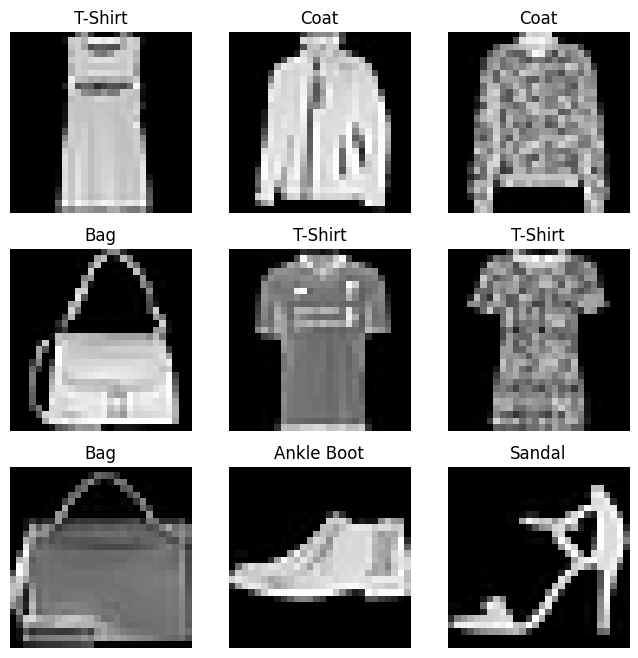

Training data length:  60000
Test data length:  10000


In [58]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

# Plot some of the images in the training data
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Print dataset length
print("Training data length: ", len(training_data))
print("Test data length: ", len(test_data))


Now we pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset, and support automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [77]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Here we can see the shape of X: 64 features of 1 x 28 x 28.
And the shape of y: 64 scalars (the label of every image in the batch).

To define a neural network in Pytorch, we create a class that inherits from "nn.Module". We define the layers of the network in the "__innit__" function and specify how data will pass through the network in the "foward" function. To acelerate operations in the neural netwok, we move it to the GPU if available.

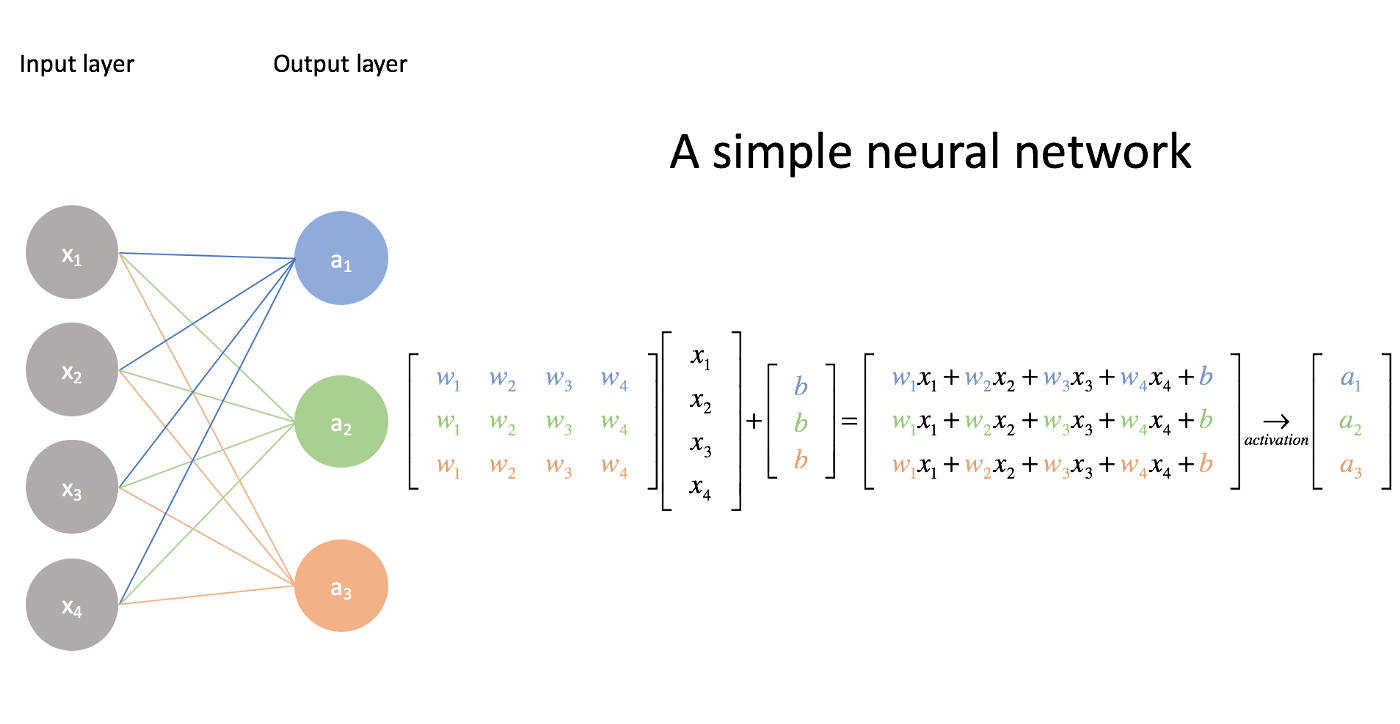

In [78]:
#Training in gpu takes more or less 19 seconds with batch size 64
#Training in cpu takes more or less 23 seconds with batch size 64

#Training in gpu takes more or less 18 seconds with batch size 128
#Training in cpu takes more or less 19 seconds with batch size 128

#Training in gpu takes more or less 16 seconds with batch size 10000
#Training in cpu takes more or less 18 seconds with batch size 10000

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__() # Innit the nn.Module
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Set the model to device
model = NeuralNetwork().to(device)
sample = torch.rand(1, 28, 28, device=device)
writer.add_graph(model, sample)
writer.close() # To run tensorboard, 'tensorboard --logdir torchlogs' 
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


For train a model we need a "loss function" and an "optimizer".

A loss function is a criterion that measure the error between the nn output and the spected output.

An optimizer is an algorithm that adjust the nn parameters.

The most common loss functions and optimizers are already implemented in Pytorch.

In [14]:
loss_fn = nn.CrossEntropyLoss()
sdg_optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
adam_optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Now we can define the training loop and the test loop.

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model's parameters.

Training steps:

1. For all epoch
2. For all batches
3. Send the batch to the model and predict
4. Calculate loss function between predicted values and spected outputs
5. Clear gradient (set the gradients to zero)
6. Compute the gradients of the loss and backpropagates it in the network.
7. Perform a single optimization step (parameter uptadate)

In [50]:
def train(dataloader, model, loss_fn, optimizer, print_label=False):
    loss_count = []
    size = len(dataloader.dataset)
    model.train() # Set the model to training mode
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) # X is the value of all images in the batch (64 x 1 x 28 x 28)
        if print_label:
            # Print all the labels of the batch mappped to the class
            print([labels_map[label.item()] for label in y])
            
        # Compute prediction error
        pred = model(X) # The model predicts the class of each image, We send all the batch to the model
        loss = loss_fn(pred, y) # The loss function compares the model's prediction and the true label

        # Backpropagation
        optimizer.zero_grad() # Clear gradients from previous step
        loss.backward() # Compute gradients of the loss w.r.t. model parameters
        optimizer.step() # Perform a single optimization step (parameter update)

        loss_count.append(loss.item())
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X) 
            
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_count

We also check the model's performance against the test dataset to ensure it is learning. 

In [16]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return 100*correct, test_loss

The training process is conducted over several iterations (epochs). During each epoch, the model learns parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the accuracy increase and the loss decrease with every epoch.

In [17]:
epoch = 5
# Using sdg optimizer
sdg_loss = []
epoch_values = []
for t in range(epoch):
    print("SDG Optimizer")
    print(f"Epoch {t+1} \n-------------------------------")
    loss_values = train(train_dataloader, model, loss_fn, sdg_optimizer)
    sdg_loss.extend(loss_values)
    test(test_dataloader, model, loss_fn)
    epoch_values.append(len(sdg_loss))
print("Done!")




SDG Optimizer
Epoch 1 
-------------------------------
loss: 2.296253  [    0/60000]
Test Error: 
 Accuracy: 12.8%, Avg loss: 2.295037 

SDG Optimizer
Epoch 2 
-------------------------------
loss: 2.294458  [    0/60000]
Test Error: 
 Accuracy: 14.5%, Avg loss: 2.293260 

SDG Optimizer
Epoch 3 
-------------------------------
loss: 2.292669  [    0/60000]
Test Error: 
 Accuracy: 16.2%, Avg loss: 2.291488 

SDG Optimizer
Epoch 4 
-------------------------------
loss: 2.290887  [    0/60000]
Test Error: 
 Accuracy: 17.8%, Avg loss: 2.289722 

SDG Optimizer
Epoch 5 
-------------------------------
loss: 2.289111  [    0/60000]
Test Error: 
 Accuracy: 19.9%, Avg loss: 2.287961 

Done!


In [18]:
# Using adam optimizer
adam_loss = []
for t in range(epoch):
    print("Adam Optimizer")
    print(f"Epoch {t+1} \n-------------------------------")
    loss_values = train(train_dataloader, model, loss_fn, adam_optimizer)
    adam_loss.extend(loss_values)
    test(test_dataloader, model, loss_fn)
print("Done!")

Adam Optimizer
Epoch 1 
-------------------------------
loss: 2.287340  [    0/60000]
Test Error: 
 Accuracy: 65.8%, Avg loss: 0.839243 

Adam Optimizer
Epoch 2 
-------------------------------
loss: 0.814755  [    0/60000]
Test Error: 
 Accuracy: 76.9%, Avg loss: 0.653281 

Adam Optimizer
Epoch 3 
-------------------------------
loss: 0.619392  [    0/60000]
Test Error: 
 Accuracy: 79.7%, Avg loss: 0.561207 

Adam Optimizer
Epoch 4 
-------------------------------
loss: 0.525537  [    0/60000]
Test Error: 
 Accuracy: 81.5%, Avg loss: 0.516450 

Adam Optimizer
Epoch 5 
-------------------------------
loss: 0.471580  [    0/60000]
Test Error: 
 Accuracy: 83.3%, Avg loss: 0.478591 

Done!


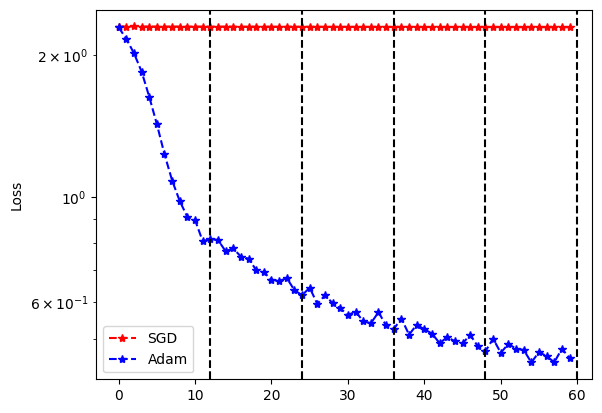

In [19]:
# Plot the loss function
plt.plot(sdg_loss, "--*", label='SGD', color='red')
plt.plot(adam_loss, "--*", label='Adam', color='blue')
for xc in epoch_values:
    plt.axvline(x=xc, color='black', linestyle='--')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()

Trained models can be saved.
A common way to save the model is to serialize the internal state dictionary (containing the model parameters).

In [20]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


The process for loading a model includes re-creating the model structure and loading the state dictionary into it

In [82]:
loadedModel = NeuralNetwork()
loadedModel.load_state_dict(torch.load("model.pth"))
params = loadedModel.state_dict()
for param in params:
    print(param, "\t", params[param].size())

linear_relu_stack.0.weight 	 torch.Size([512, 784])
linear_relu_stack.0.bias 	 torch.Size([512])
linear_relu_stack.2.weight 	 torch.Size([512, 512])
linear_relu_stack.2.bias 	 torch.Size([512])
linear_relu_stack.4.weight 	 torch.Size([10, 512])
linear_relu_stack.4.bias 	 torch.Size([10])


This model can now be used to make predictions.

In [22]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

loadedModel.eval() # Put the model in inference mode
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = loadedModel(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


We can see the prediction is correct!

Now let's experiment with the batch size. 

Sometimes a large batch size (faster processing time) can cause our model to not learn. That is because we don't make enough optimization steps to find the best parameters of the model. Otherwise, if our batch size is too small (slower processing time), the loss won't represent the mean error of our network, and the optimizacion steps won't be correct.

Lets test and plot.


In [31]:

batch_num = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]
accuracy_values = []
loss_test_values = []


for i in batch_num:
    test_batch_model = NeuralNetwork().to(device)
    sdg_optimizer = torch.optim.SGD(test_batch_model.parameters(), lr=1e-3)
    train_batch_dataloader = DataLoader(dataset = training_data,batch_size=i, shuffle=False)
    test_batch_dataloader = DataLoader(dataset=test_data, batch_size=i, shuffle=False)

    for t in range(epoch):
        print("SDG Optimizer")
        print(f"Epoch {t+1} \n-------------------------------")
        train(train_batch_dataloader, test_batch_model, loss_fn, sdg_optimizer)
        accuracy, loss_test = test(test_batch_dataloader, test_batch_model, loss_fn)

    accuracy_values.append(accuracy)
    loss_test_values.append(loss_test)



SDG Optimizer
Epoch 1 
-------------------------------
loss: 2.315134  [    0/60000]
loss: 2.306251  [  800/60000]
loss: 2.260715  [ 1600/60000]
loss: 2.249552  [ 2400/60000]
loss: 2.273652  [ 3200/60000]
loss: 2.225717  [ 4000/60000]
loss: 2.233862  [ 4800/60000]
loss: 2.197994  [ 5600/60000]
loss: 2.187007  [ 6400/60000]
loss: 2.215585  [ 7200/60000]
loss: 2.142366  [ 8000/60000]
loss: 2.142514  [ 8800/60000]
loss: 2.130803  [ 9600/60000]
loss: 2.100955  [10400/60000]
loss: 2.024390  [11200/60000]
loss: 2.107095  [12000/60000]
loss: 2.092173  [12800/60000]
loss: 1.824335  [13600/60000]
loss: 1.824470  [14400/60000]
loss: 1.773222  [15200/60000]
loss: 1.976877  [16000/60000]
loss: 1.592936  [16800/60000]
loss: 1.905407  [17600/60000]
loss: 1.688439  [18400/60000]
loss: 1.689247  [19200/60000]
loss: 1.823079  [20000/60000]
loss: 1.518223  [20800/60000]
loss: 1.668936  [21600/60000]
loss: 1.535116  [22400/60000]
loss: 1.555637  [23200/60000]
loss: 1.492297  [24000/60000]
loss: 1.505637 

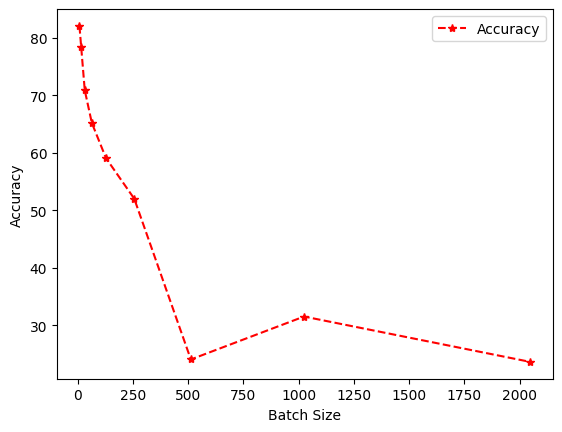

In [32]:
# Plot accuracy vs batch size
plt.plot(batch_num, accuracy_values, "--*", label='Accuracy', color='red')
plt.ylabel('Accuracy')
plt.xlabel('Batch Size')
plt.legend()

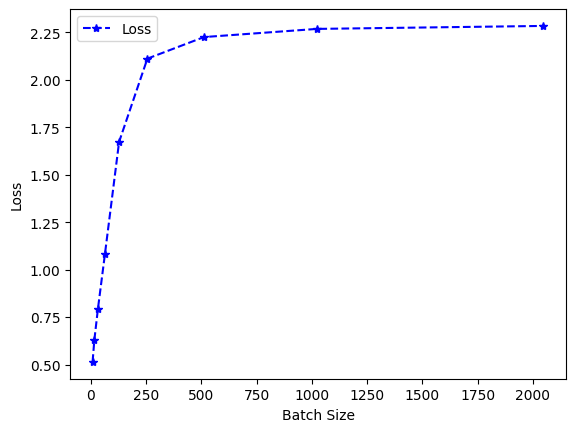

In [33]:
# Plot loss vs batch size
plt.plot(batch_num, loss_test_values, "--*", label='Loss', color='blue')
plt.ylabel('Loss')
plt.xlabel('Batch Size')
plt.legend()

SDG Optimizer
Epoch 1 
-------------------------------
loss: 2.276255  [    0/60000]
loss: 2.382975  [  200/60000]
loss: 2.171219  [  400/60000]
loss: 1.747908  [  600/60000]
loss: 1.615929  [  800/60000]
loss: 0.797175  [ 1000/60000]
loss: 1.368827  [ 1200/60000]
loss: 0.949241  [ 1400/60000]
loss: 2.351019  [ 1600/60000]
loss: 1.039197  [ 1800/60000]
loss: 0.945379  [ 2000/60000]
loss: 0.283136  [ 2200/60000]
loss: 1.854296  [ 2400/60000]
loss: 1.825699  [ 2600/60000]
loss: 0.752960  [ 2800/60000]
loss: 1.380693  [ 3000/60000]
loss: 0.157014  [ 3200/60000]
loss: 0.969155  [ 3400/60000]
loss: 2.167651  [ 3600/60000]
loss: 0.924490  [ 3800/60000]
loss: 0.167669  [ 4000/60000]
loss: 0.317274  [ 4200/60000]
loss: 0.527646  [ 4400/60000]
loss: 0.398294  [ 4600/60000]
loss: 0.973108  [ 4800/60000]
loss: 0.600622  [ 5000/60000]
loss: 0.081140  [ 5200/60000]
loss: 0.591234  [ 5400/60000]
loss: 2.491690  [ 5600/60000]
loss: 0.116427  [ 5800/60000]
loss: 1.112611  [ 6000/60000]
loss: 0.028338 

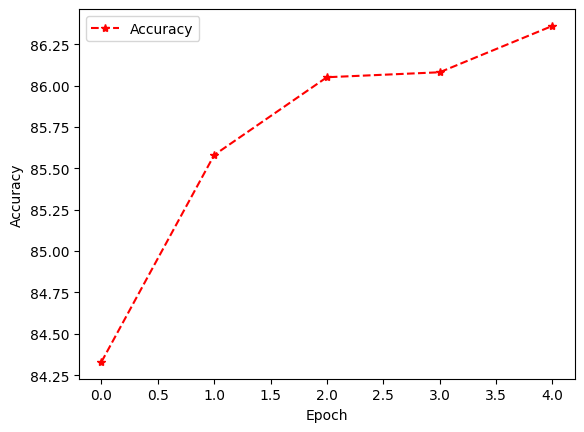

In [84]:
batch_num = [2]
accuracy_values = []
loss_test_values = []


for i in batch_num:
    test_batch_model = NeuralNetwork().to(device)
    sdg_optimizer = torch.optim.SGD(test_batch_model.parameters(), lr=1e-2)
    train_batch_dataloader = DataLoader(dataset = training_data,batch_size=i)
    test_batch_dataloader = DataLoader(dataset=test_data, batch_size=i)

    for t in range(epoch):
        print("SDG Optimizer")
        print(f"Epoch {t+1} \n-------------------------------")
        train(train_batch_dataloader, test_batch_model, loss_fn, sdg_optimizer, print_label=False)
        accuracy, loss_test = test(test_batch_dataloader, test_batch_model, loss_fn)

        accuracy_values.append(accuracy)
        loss_test_values.append(loss_test)

# Plot accuracy vs batch size
plt.plot(accuracy_values, "--*", label='Accuracy', color='red')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
